In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import folium 
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
import sqlite3
import requests
import geopandas as gpd
from utils import get_osrm_distance 
from utils import haversine_distance
import requests
from pyproj import Transformer
import os
from tqdm import tqdm, trange
import bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, MultiLine
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import export_png
from bokeh.models import LabelSet
from selenium import webdriver


In [6]:
data = pd.read_csv('ChargingStationCleaned.csv')
data['year'] = pd.to_datetime(data['commissioning_date']).dt.year

In [7]:
from shapely.geometry import Point, Polygon

# Crea una nuova colonna 'geometry' nel DataFrame che rappresenta ogni punto (stazione di ricarica)
data['geometry'] = data.apply(lambda row: Point(row['longitude_[dg]'], row['latitude_[dg]']), axis=1)

# Converti il DataFrame in un GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Crea un GeoDataFrame per i confini della Germania
germany_boundary = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/4090d4e1f89c1184b436b3d9ccaf332b4c5b43d2/2_bundeslaender/4_niedrig.geo.json')

# Crea un poligono unico dai confini della Germania
germany_polygon = germany_boundary.geometry.unary_union

# Filtra il GeoDataFrame per includere solo i punti all'interno dei confini della Germania
gdf = gdf[gdf.geometry.within(germany_polygon)]

# Converti il GeoDataFrame filtrato in un DataFrame
data = pd.DataFrame(gdf)


In [8]:
data.head()

,operator,address,house_number,placeholder1,postcode,city,federal_state,metropolitan_area,latitude_[dg],longitude_[dg],...,type_of_plug_1,p1_[kw],type_of_plug_2,p2_[kw],type_of_plug_3,p3_[kw],type_of_plug_4,p4_[kw],year,geometry
0,EnBW mobility+ AG und Co.KG,Hauptstraï¿½e,91c,NaN,73340,Amstetten,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.578534,9.874840,...,AC Kupplung Typ 2,43.0,"DC Kupplung Combo, DC CHAdeMO",50.0,0,0.0,0,0.0,2019,POINT (9.87484 48.57853)
1,SWU Energie GmbH,Lindenstraï¿½e,7,NaN,89176,Asselfingen,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.528983,10.193397,...,AC Steckdose Typ 2,22.0,0,0.0,0,0.0,0,0.0,2019,POINT (10.19340 48.52898)
2,SWU Energie GmbH,ï¿½llengasse,10,NaN,89177,Ballendorf,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.553539,10.082678,...,AC Steckdose Typ 2,22.0,AC Steckdose Typ 2,22.0,0,0.0,0,0.0,2019,POINT (10.08268 48.55354)
3,SWU Energie GmbH,Sterngasse,6,NaN,88481,Balzheim,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.179959,10.076977,...,AC Steckdose Typ 2,22.0,0,0.0,0,0.0,0,0.0,2022,POINT (10.07698 48.17996)
4,EnBW mobility+ AG und Co.KG,Heuweg,12,NaN,89179,Beimerstetten,Baden-Wï¿½rttemberg,Landkreis Alb-Donau-Kreis,48.480387,9.980588,...,"AC Steckdose Typ 2, AC Schuko",22.0,"AC Steckdose Typ 2, AC Schuko",22.0,0,0.0,0,0.0,2019,POINT (9.98059 48.48039)


In [9]:
def create_network(year, max_distance=100):
    data_year = data[data['year'] <= year]
    n = len(data_year)
    positions = data_year[['latitude_[dg]', 'longitude_[dg]']].to_numpy()

    # Converti le coordinate geografiche in coordinate UTM
    transformer = Transformer.from_crs('epsg:4326', 'epsg:32632', always_xy=True)
    positions_utm = np.array([transformer.transform(x[1], x[0]) for x in positions])

    network = nx.Graph()
    
    # Aggiungi i nodi al grafo con attributi di latitudine e longitudine
    for i in tqdm(range(n), desc="Adding nodes"):
        network.add_node(i + 1, latitude=positions[i, 0], longitude=positions[i, 1])

    for i in tqdm(range(n), desc="Adding edges"):
        for j in range(i + 1, n):  # Evita di ripetere gli archi
            # distance = get_osrm_distance(positions_utm[i, 0], positions_utm[i, 1], positions_utm[j, 0], positions_utm[j, 1])
            distance = get_osrm_distance(positions[i, 0], positions[i, 1], positions[j, 0], positions[j, 1])
            if distance is not None and distance < max_distance * 1000:  # Converti max_distance in metri
                network.add_edge(i + 1, j + 1, weight=distance)

    pos = {i + 1: positions_utm[i] for i in range(n)}

    options = {
        'node_color': 'lavender',
        'node_size': 10,
        'width': 1,
        # 'arrowstyle': '->',
        'arrowsize': 1,
    }

    # # Leggi il file GeoJSON dei confini della Germania
    germany_boundary = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/4090d4e1f89c1184b436b3d9ccaf332b4c5b43d2/2_bundeslaender/4_niedrig.geo.json')

    # # Converti le coordinate geografiche in coordinate UTM
    germany_boundary = germany_boundary.to_crs('epsg:32632')

    # # Crea un nuovo plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # # Disegna il network
    nx.draw_networkx(network, pos=pos, ax=ax, **options)

    # # Disegna i confini della Germania
    germany_boundary.boundary.plot(ax=ax, linewidth=2, color='red', zorder=3)

    # # Crea le cartelle se non esistono
    if not os.path.exists("network_graphs_figure"):
        os.makedirs("network_graphs_figure")
    if not os.path.exists("network_graphs_save"):
        os.makedirs("network_graphs_save")

    # # Imposta i titoli e visualizza il grafico
    # plt.title(f'EV charging stations network ({year}) of BEV with 100 km range', fontsize=15)
    plt.show()

    nx.write_graphml(network, f"network_graphs_save/network_{year}_{max_distance}.graphml")
    
    # # Salva il grafico come file PNG nella cartella "network_graphs_figure"
    fig.savefig(f"network_graphs_figure/network_{year}_{max_distance}.png", dpi=300, bbox_inches="tight")

    # ================================================== Graph
    # # Crea un nuovo plot
    # p = figure(x_axis_label='X', y_axis_label='Y', toolbar_location=None)
    # p.xaxis.visible = False
    # p.yaxis.visible = False

    # # Aggiungi gli archi al plot
    # edge_xs = [[pos[edge[0]][0], pos[edge[1]][0]] for edge in network.edges()]
    # edge_ys = [[pos[edge[0]][1], pos[edge[1]][1]] for edge in network.edges()]

    # source_edges = ColumnDataSource(dict(xs=edge_xs, ys=edge_ys))
    # p.add_glyph(source_edges, MultiLine(xs='xs', ys='ys', line_color='black'))

    # # Aggiungi i nodi al plot
    # source_nodes = ColumnDataSource(dict(x=[p[0] for p in pos.values()], y=[p[1] for p in pos.values()]))
    # p.circle(x='x', y='y', size=5, color='lavender', source=source_nodes)

    # # Disegna i confini della Germania
    # for _, row in germany_boundary.iterrows():
    #     if row['geometry'].geom_type == 'Polygon':
    #         xs, ys = row['geometry'].exterior.xy
    #         p.line(xs, ys, color='red', line_width=2)
    #     elif row['geometry'].geom_type == 'MultiPolygon':
    #         for polygon in row['geometry'].geoms:
    #             xs, ys = polygon.exterior.xy
    #             p.line(xs, ys, color='red', line_width=2)

    # # Aggiungi gli archi al plot
    # edge_xs = [[pos[edge[0]][0], pos[edge[1]][0]] for edge in network.edges()]
    # edge_ys = [[pos[edge[0]][1], pos[edge[1]][1]] for edge in network.edges()]

    # source_edges = ColumnDataSource(dict(xs=edge_xs, ys=edge_ys))
    # p.add_glyph(source_edges, MultiLine(xs='xs', ys='ys', line_color='black'))

    # # Aggiungi i nodi al plot
    # source_nodes = ColumnDataSource(dict(x=[p[0] for p in pos.values()], y=[p[1] for p in pos.values()]))
    # p.circle(x='x', y='y', size=5, color='lavender', source=source_nodes)

    # # Aggiungi le etichette dei nodi
    # source_labels = ColumnDataSource(data=dict(x=list(x for x, _ in pos.values()), y=list(y for _, y in pos.values()), text=list(network.nodes())))
    # labels = LabelSet(x='x', y='y', text='text', source=source_labels, text_color='black', text_font_size='8pt', x_offset=5, y_offset=5)
    # p.add_layout(labels)

    # # Visualizza il grafico
    # output_file(f"network_graphs_figure/network_{year}_{max_distance}.html")  # Salva il grafico come file HTML
    # # show(p)  # Mostra il grafico in una nuova finestra del browser

    # # Crea un'istanza del WebDriver di Safari
    # safari_driver = webdriver.Safari()

    # # Salva il grafico come file PNG nella cartella "network_graphs_figure"
    # export_png(p, filename=f"network_graphs_figure/network_bokeh_{year}_{max_distance}.png", webdriver=safari_driver)



Adding edges: 100%|██████████| 60/60 [00:00<00:00, 11962.65it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


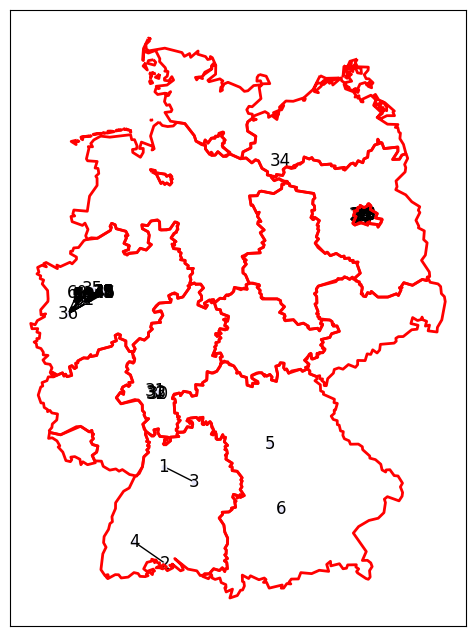

In [10]:
create_network(2009)

Adding edges: 100%|██████████| 130/130 [00:00<00:00, 4520.25it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


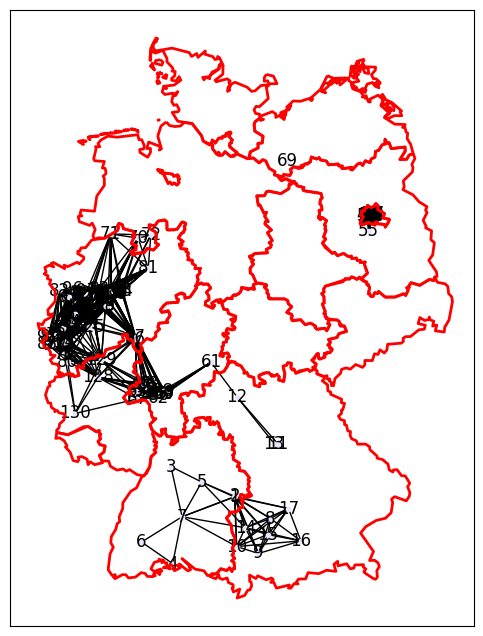

In [11]:
create_network(2010)

Adding edges: 100%|██████████| 320/320 [00:00<00:00, 2234.27it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


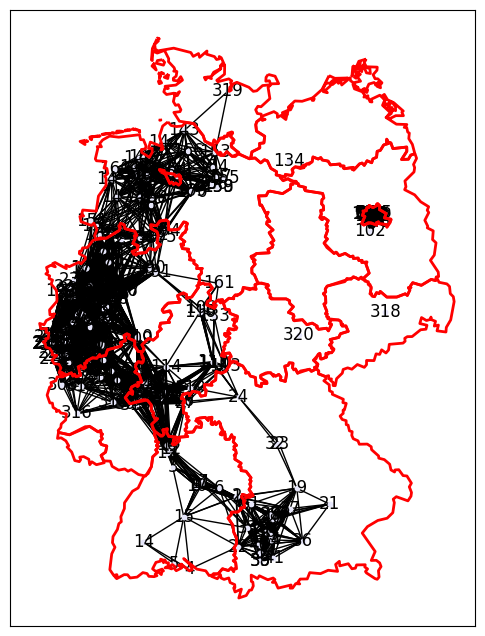

In [12]:
create_network(2011)

Adding edges: 100%|██████████| 494/494 [00:00<00:00, 1594.57it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


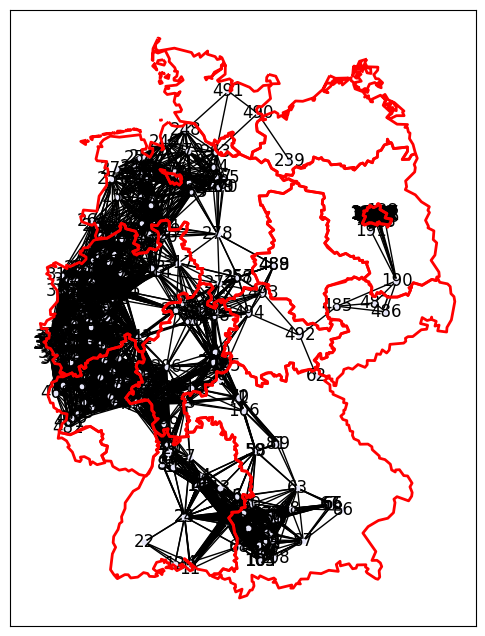

In [13]:
create_network(2012)

Adding edges: 100%|██████████| 615/615 [00:00<00:00, 1223.13it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


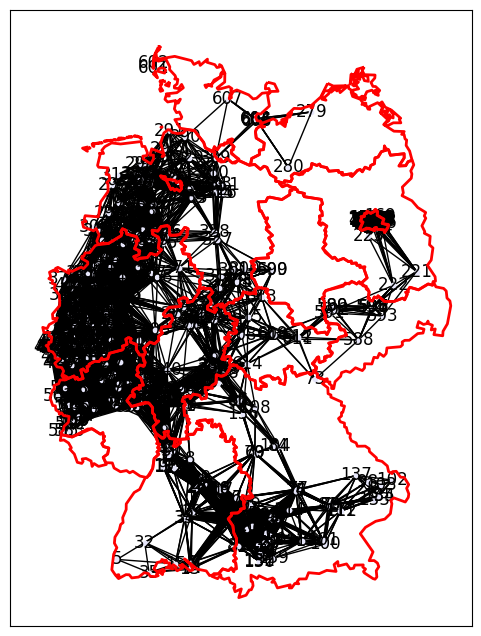

In [14]:
create_network(2013)

Adding edges: 100%|██████████| 861/861 [00:00<00:00, 917.19it/s] 
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


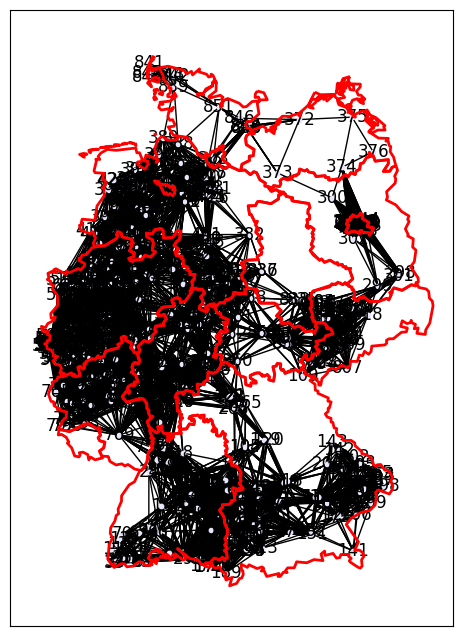

In [15]:
create_network(2014)

Adding edges: 100%|██████████| 1393/1393 [00:02<00:00, 479.98it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


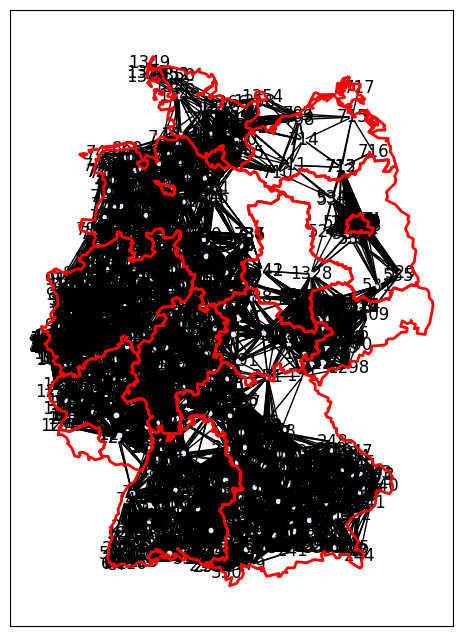

In [16]:
create_network(2015)

Adding edges: 100%|██████████| 2503/2503 [00:07<00:00, 328.53it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


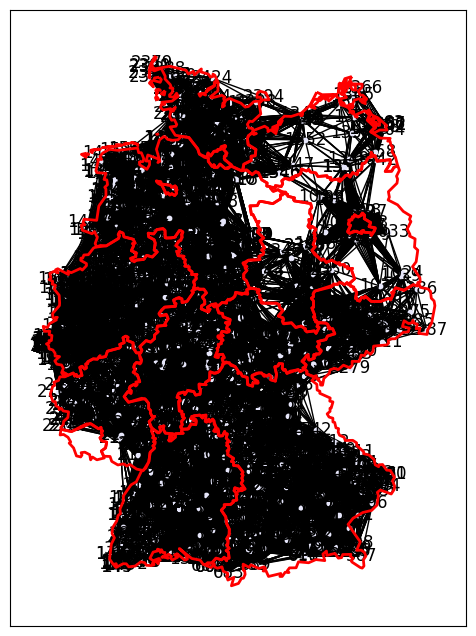

In [17]:
create_network(2016)

Adding edges: 100%|██████████| 4350/4350 [00:23<00:00, 186.61it/s]
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


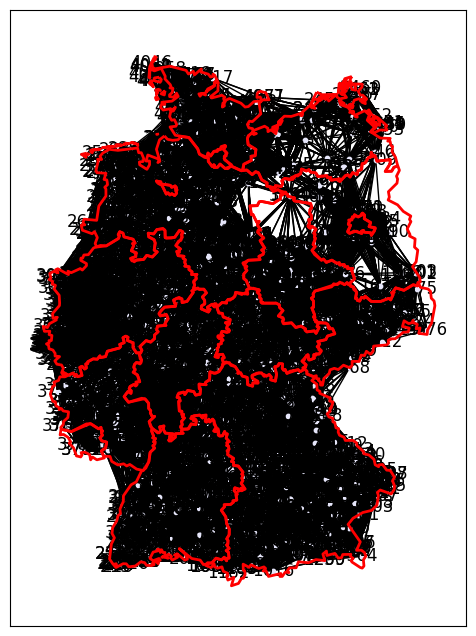

In [18]:
create_network(2017)

In [20]:
create_network(2018)

Adding edges: 100%|██████████| 8135/8135 [01:20<00:00, 100.44it/s]


URLError: <urlopen error Tunnel connection failed: 407 Proxy Authentication Required>

In [21]:
create_network(2019)

Adding edges: 100%|██████████| 13012/13012 [03:25<00:00, 63.22it/s]  


URLError: <urlopen error Tunnel connection failed: 407 Proxy Authentication Required>

Adding edges: 100%|██████████| 18279/18279 [07:17<00:00, 41.82it/s] 
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


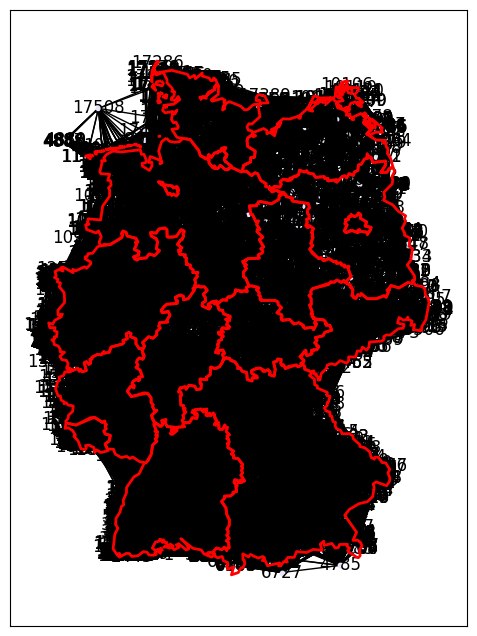

In [ ]:
create_network(2020)

Adding edges: 100%|██████████| 25252/25252 [15:34<00:00, 27.02it/s]  
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


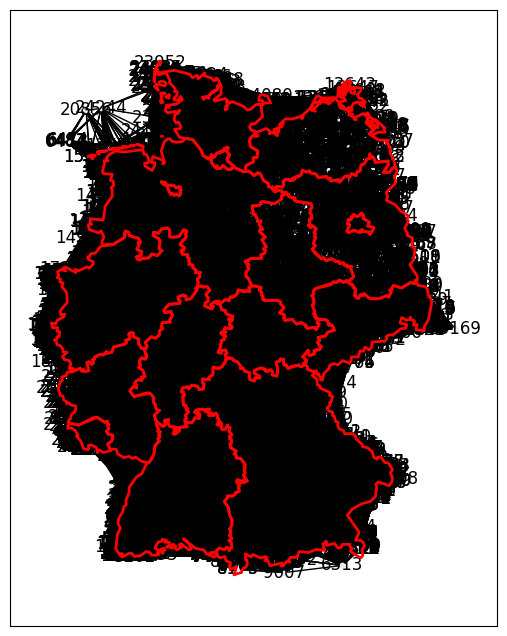

In [ ]:
create_network(2021)

Adding edges: 100%|██████████| 29733/29733 [20:48<00:00, 23.82it/s]  
C:\Users\Q540900\AppData\Roaming\Python\Python37\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


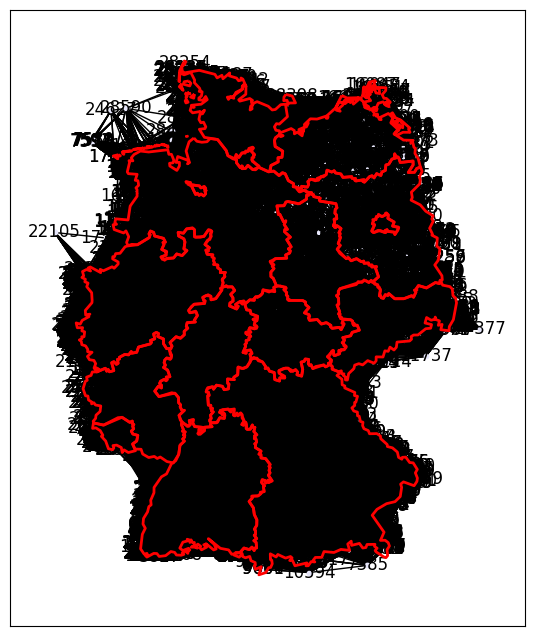

In [ ]:
create_network(2022)

In [ ]:
# 18700